This notebook explores AutoML using Scalable Spark MLLib algorithms.
The data used in this notebook was obtained from http://www.andresmh.com/nyctaxitrips/.


### Outline:
1. Load Data
2. Data Preparation and Analysis
3. AutoML Experiment


### Libraries:
- Spark MLLib 
- Microsoft MMLSpark - https://github.com/Azure/mmlspark/blob/master/docs/lightgbm.md
- MLFlow
- AzureML - AutoML

Broadly a machine learning experiment has three distinct steps - 
    1. Loading the dataset from a given source,
    2. Doing some exploratory data analysis, to understand the data and the problem, and pre-processing it to make it ready for training a model
    3. And then finally, training and evaluating a model

The third part is where AutoML helps users to automatically select a model that best fits the given data

# 1. Loading Data

The entire NYC Taxi dataset is ~17GB in size, split across two tables each spanning multiple CSV files - one which contains information on the fares (e.g. total fare, tip amount etc.), and the other which contains information on the trips (e.g. pickup / dropoff location, trip duration etc.).

In [0]:
%fs ls dbfs:/databricks/datasets/nycfull

path,name,size
dbfs:/databricks/datasets/nycfull/trip_data_1.csv,trip_data_1.csv,2459600863
dbfs:/databricks/datasets/nycfull/trip_data_10.csv,trip_data_10.csv,2502278613
dbfs:/databricks/datasets/nycfull/trip_data_11.csv,trip_data_11.csv,2395449056
dbfs:/databricks/datasets/nycfull/trip_data_12.csv,trip_data_12.csv,2327237611
dbfs:/databricks/datasets/nycfull/trip_data_2.csv,trip_data_2.csv,2328673265
dbfs:/databricks/datasets/nycfull/trip_data_3.csv,trip_data_3.csv,2622301287
dbfs:/databricks/datasets/nycfull/trip_data_4.csv,trip_data_4.csv,2515040578
dbfs:/databricks/datasets/nycfull/trip_data_5.csv,trip_data_5.csv,2545680024
dbfs:/databricks/datasets/nycfull/trip_data_6.csv,trip_data_6.csv,2396133818
dbfs:/databricks/datasets/nycfull/trip_data_7.csv,trip_data_7.csv,2303297474


### Loading using Pandas
Due to the size of this dataset, we are inherently limited by the amount of memory we have on a single machine to load this dataset. The following cell outlines how we would load the NYC Taxi fares dataset using pandas, however it has been commented out due to the fact that we run into an out of memory (OOM) error.

In [0]:
# import pandas as pd

# column_names = [
#     "medallion", "hack_license", "vendor_id", "pickup_datetime", "payment_type",
#     "fare_amount","surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"
# ]

# pdf = pd.read_csv("/databricks/datasets/nycfull/trip_data_*.csv", header=0, names=column_names)
# pdf.head()

### Load the entire NYC dataset using Koalas

Koalas recreates the pandas API, using Apache Spark under the hood. Using it, we are now able to load the same dataset using Koalas' equivalent read_csv function.

Also note the `ks.set_option('compute.default_index_type', 'distributed')` line below.
Pandas uses a monotonically increasing index by default (e.g., [0,1,2..]), which is the same for Koalas. However, it is not suitable for large datasets.

Here, we're setting the `default_index_type` to be `distributed` - which means that the index increases monotonically, but there are indeterministic gaps in the numbers assigned. We select this index type as our dataset is relatively large and we will not explicitly require an index that monotonically increases one-by-one.

In [0]:
import databricks.koalas as ks
ks.set_option('compute.default_index_type', 'distributed')

#### Load NYC Fares Dataset

In addition to containing some common fields like the driver details, this dataset contains details on fare amount, the tolls and surcharge taxes, and the tip amount.

In [0]:
column_names = [
    "medallion", "hack_license", "vendor_id", "pickup_datetime", "payment_type",
    "fare_amount","surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"
]
nyc_fares = ks.read_csv("dbfs:/databricks/datasets/nycfull/trip_fare_*.csv", header=0, names=column_names)
nyc_fares.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
8589934592,C2C60286DB4211BB6CBD046EF7F147E9,083D8CEB07A9C923F1D931FD44CF64DC,VTS,2013-01-02 12:34:00,CSH,10.5,0.0,0.5,0.0,0.0,11.0
8589934593,72481E5CAC40B72474735B4E976E7289,237241BEB99836E08F5B7938F9C861B5,VTS,2013-01-02 12:37:00,CSH,4.5,0.0,0.5,0.0,0.0,5.0
8589934594,7FF8BE125EFDEB1D1FBD4B21CFA94245,553F8EDB18F4532BB5BD8A2D4C5AC2EF,VTS,2013-01-02 13:24:00,CSH,20.0,0.0,0.5,0.0,0.0,20.5
8589934595,2A206801A42E7E225C917753FC0DD27D,32DDCDE76F12CFC1EB8E4B900E85CD13,VTS,2013-01-02 13:34:00,CSH,10.0,0.0,0.5,0.0,0.0,10.5
8589934596,6A5786D5702B59C611C78C846E44EAEC,C73CC5B4772C0803021069CFBB259510,VTS,2013-01-02 13:37:00,CSH,7.5,0.0,0.5,0.0,0.0,8.0


In [0]:
nyc_fares.shape

Out[6]: (173179759, 11)

#### Load NYC Trips Dataset

The trip data consists of driver details (medallion, hack_license, vendor_id) and trip details such as pickup and dropoff times, the number of passengers, trip time and distance, and the GPS coordinates of the pickup and dropoff.

In [0]:
nyc_trips = ks.read_csv("dbfs:/databricks/datasets/nycfull/trip_data_*.csv")
nyc_trips.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
17179869184,3A15A182176A6707F973D236EEE23B92,0B46E6CFF11EC4C7B9676413F23453B2,VTS,1,None,2013-01-04 13:08:00,2013-01-04 13:38:00,2,1800,4.23,-73.952377,40.791573,-73.97876,40.764816
17179869185,FCB1BF2054823AB4F0D2A35BB5A26A11,B57F4989DB32ED4D4CC2A9CFDED8AEDB,VTS,1,None,2013-01-04 13:28:00,2013-01-04 13:39:00,1,660,1.28,-73.978615,40.752796,-73.990562,40.749138
17179869186,6C9F67DF658DC5636F9E7752F203F70A,8B526AEEA53D64E414745E1667BDD850,VTS,1,None,2013-01-04 13:32:00,2013-01-04 13:38:00,1,360,1.37,-73.972237,40.758846,-73.983788,40.743446
17179869187,6B7854AB74AF4DE334E8A7932268E3C7,72B5F9275F120251A58ED88EE2F4CA5E,VTS,1,None,2013-01-04 13:18:00,2013-01-04 13:36:00,5,1080,2.26,-74.009026,40.715946,-73.986671,40.703182
17179869188,7C534E2A6F98E50D524C2729B07CE60E,C72D41043CDBABC1AEB7DA1924540D83,VTS,1,None,2013-01-04 13:33:00,2013-01-04 13:37:00,5,240,.87,-73.982254,40.745907,-73.975204,40.755817


In [0]:
nyc_trips.shape

Out[8]: (173179759, 14)

# Preprocessing Data + Exploratory Data Analysis

Having loaded the two datasets, we can now explore it, and prepare it for a machine learning experiment.

Let's take a look at the columns contained in both the DataFrames.

In [0]:
import pprint

output = {}
output['NYC Fares'] = list(nyc_fares.columns)
output['NYC Trips'] = list(nyc_trips.columns)

pprint.pprint(output)

{'NYC Fares': ['medallion',
 'hack_license',
 'vendor_id',
 'pickup_datetime',
 'payment_type',
 'fare_amount',
 'surcharge',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount'],
 'NYC Trips': ['medallion',
 'hack_license',
 'vendor_id',
 'rate_code',
 'store_and_fwd_flag',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude']}

The column `pickup_datetime` is repeated in both the tables, let's drop it from one of the them.

In [0]:
nyc_fares = nyc_fares.drop(columns=["pickup_datetime"])
nyc_fares.columns

Out[10]: Index(['medallion', 'hack_license', 'vendor_id', 'payment_type', 'fare_amount',
 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'],
 dtype='object')

### Join (flatten) the two datasets in a single dataframe

We will joing the two datasets along `medallion`, `hack_license`, and `vendor_id`, as together they uniquely define each row in both the datasets.

Joining large datasets along index columns greatly improves the performance. Hence, we first need to set the index columns for the two datasets. Note that this can also be set at read time (e.g. via. `read_csv`).

In [0]:
index_column_names = ["medallion", "hack_license", "vendor_id"]

nyc_fares = nyc_fares.set_index(index_column_names)
nyc_trips = nyc_trips.set_index(index_column_names)

print("NYC Fares index columns: ", nyc_fares.index.names)
print("NYC Trips index columns: ", nyc_fares.index.names)

NYC Fares index columns: ['medallion', 'hack_license', 'vendor_id']
NYC Trips index columns: ['medallion', 'hack_license', 'vendor_id']

In [0]:
nyc_flattened_data = nyc_fares.join(nyc_trips, how="inner").dropna()

print("Columns: ", nyc_flattened_data.columns)
print("Index: ", nyc_flattened_data.index.names)

Columns: Index(['payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
 'tolls_amount', 'total_amount', 'rate_code', 'store_and_fwd_flag',
 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
 'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
 dtype='object')
Index: ['medallion', 'hack_license', 'vendor_id']

In [0]:
nyc_flattened_data.shape

Out[24]: (3207168346, 18)

#### Joining via. Spark SQL

DataFrames can also be joined using SQL queries directly.

In [0]:
# nyc_flattened_data = ks.sql("""
# SELECT * 
# FROM {nyc_fares} f, {nyc_trips} t
# WHERE 
#     f.medallion == t.medallion and 
#     f.hack_license == t.hack_license and 
#     f.vendor_id == t.vendor_id
# """)

### Getting column statistics

The .describe() method in Koalas is similar to that in pandas, showing a statistical summary of each numerical feature:

In [0]:
nyc_flattened_data.describe()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09,3.207168e+09
mean,1.131783e+01,3.202964e-01,4.983538e-01,1.247499e+00,1.810397e-01,1.356502e+01,1.029057e+00,1.256959e+00,6.689058e+02,2.658711e+00,-7.265601e+01,4.002438e+01,-7.266756e+01,4.003151e+01
std,9.049336e+00,3.694655e-01,2.864279e-02,1.969798e+00,9.763490e-01,1.081783e+01,3.526562e-01,6.072264e-01,4.790509e+02,3.158865e+00,9.794745e+00,5.395749e+00,9.748516e+00,5.370356e+00
min,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.793612e+02,-3.976235e+01,-1.793612e+02,0.000000e+00
25%,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,7.500000e+00,1.000000e+00,1.000000e+00,3.450000e+02,1.000000e+00,-7.399189e+01,4.073628e+01,-7.399132e+01,4.073506e+01
50%,8.500000e+00,0.000000e+00,5.000000e-01,8.000000e-01,0.000000e+00,1.050000e+01,1.000000e+00,1.000000e+00,5.530000e+02,1.700000e+00,-7.398165e+01,4.075348e+01,-7.398008e+01,4.075395e+01
75%,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.500000e+01,1.000000e+00,1.000000e+00,8.610000e+02,3.000000e+00,-7.396703e+01,4.076771e+01,-7.396407e+01,4.076838e+01
max,5.000000e+02,1.250000e+01,5.000000e-01,1.500000e+02,2.000000e+01,6.500000e+02,2.100000e+02,6.000000e+00,1.026500e+04,1.000000e+02,1.124042e+02,8.251405e+01,1.114939e+02,8.351669e+01


### Identify missing values in the DataFrame, if any.

In [0]:
nyc_flattened_data.isna().sum()

Out[26]: payment_type 0
fare_amount 0
surcharge 0
mta_tax 0
tip_amount 0
tolls_amount 0
total_amount 0
rate_code 0
store_and_fwd_flag 0
pickup_datetime 0
dropoff_datetime 0
passenger_count 0
trip_time_in_secs 0
trip_distance 0
pickup_longitude 0
pickup_latitude 0
dropoff_longitude 0
dropoff_latitude 0
dtype: int64

### Drill down into column specific statistics

In [0]:
nyc_flattened_data['store_and_fwd_flag'].value_counts()

Out[27]: N 3138138506
Y 69029840
Name: store_and_fwd_flag, dtype: int64

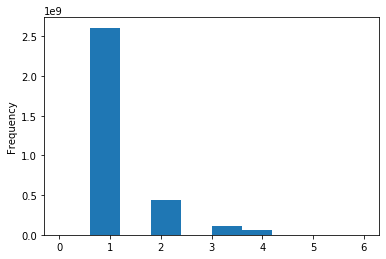

In [0]:
nyc_flattened_data["passenger_count"].plot.hist()

## Prepare the target column

Given the driver and trip details, into which bin will a passenger tip fall? What is the current distribution of tips? Let's bucketize the tips in the following classes:

```
Class 0 : Tip = $0
Class 1 : Tip > $0 and Tip < $1
Class 2 : Tip >= $1 and Tip < $5
Class 3 : Tip >= $5 and Tip < $20
Class 4 : Tip >= $20
```

In [0]:
def binning(row):
    if row.tip_amount == 0:
        return 0
    elif row.tip_amount < 1:
        return 1
    elif row.tip_amount < 5:
        return 2
    elif row.tip_amount < 20:
        return 3
    else:
        return 4

bins = nyc_flattened_data.apply(binning, axis=1)

In [0]:
nyc_flattened_data.sample(frac=0.001, random_state=12345).reset_index().to_parquet("dbfs:/databricks/datasets/nycfull/nyc_joined_sampled.parquet")

In [0]:
kdf = ks.read_parquet("dbfs:/databricks/datasets/nycfull/nyc_joined_sampled.parquet")
kdf.shape
nyc_flattened_data = kdf

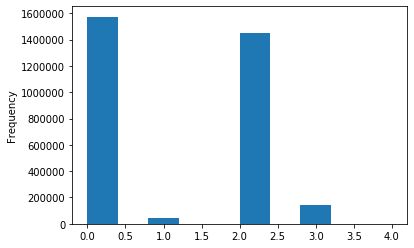

In [0]:
bins.plot.hist()

The data is imbalanced for the chosen buckets. So we would need to handle this (via. assigning weights to the classes).
We can also slightly change the problem to simplify this. Instead of identifying which bucket of tips a trip will fall into, let's instead figure out that given trip information, would it result in a non-zero tip amount. This is a binary classification problem now.

In [0]:
binary_bins = nyc_flattened_data.apply(lambda row: 0 if row.tip_amount > 0 else 1, axis=1)

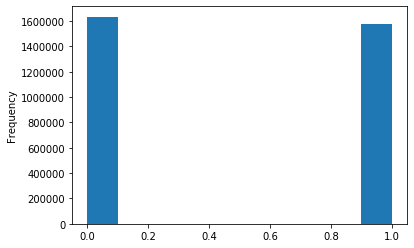

In [0]:
binary_bins.plot.hist()

Koalas disallows the operations on different DataFrames (or Series) by default to prevent expensive operations. It internally performs a join operation which can be expensive in general. To override this behavior we need to enable the property `compute.ops_on_diff_frames`.

In [0]:
ks.set_option("compute.ops_on_diff_frames", True)
nyc_flattened_data['target'] = binary_bins
nyc_flattened_data = nyc_flattened_data.drop("tip_amount")

nyc_flattened_data.columns

Out[27]: Index(['medallion', 'hack_license', 'vendor_id', 'payment_type', 'fare_amount',
 'surcharge', 'mta_tax', 'tolls_amount', 'total_amount', 'rate_code',
 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
 'passenger_count', 'trip_time_in_secs', 'trip_distance',
 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
 'dropoff_latitude', 'target'],
 dtype='object')

Let's look at the correlation matrix for the combined DataFrame, to see if there's anything obvious that is correlated with the target column. This gives us a good estimate if there are leaky features, as they will rank very high in the correlation matrix.

In [0]:
corr = nyc_flattened_data.dropna().corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,target
fare_amount,1,-0.049,-0.31,0.57,0.98,0.019,0.0064,0.028,0.038,0.00076,-0.00078,0.00037,-0.00041,-0.091
surcharge,-0.049,1,0.039,-0.058,-0.013,0.0042,0.051,-0.0031,0.029,0.003,-0.0034,0.003,-0.0033,-0.02
mta_tax,-0.31,0.039,1,-0.25,-0.31,-0.0069,-0.0021,-0.0026,-0.0052,-0.00059,0.00061,-0.001,0.001,0.014
tolls_amount,0.57,-0.058,-0.25,1,0.63,0.013,0.0032,0.02,0.026,-0.00043,0.00048,-0.00088,0.00088,-0.049
total_amount,0.98,-0.013,-0.31,0.63,1,0.019,0.0083,0.028,0.038,0.00079,-0.00082,0.00037,-0.00042,-0.19
rate_code,0.019,0.0042,-0.0069,0.013,0.019,1,0.015,0.14,0.22,0.001,-0.001,0.0006,-0.00076,-0.00071
passenger_count,0.0064,0.051,-0.0021,0.0032,0.0083,0.015,1,0.045,0.03,-0.0011,0.00095,-0.0019,0.0018,-0.002
trip_time_in_secs,0.028,-0.0031,-0.0026,0.02,0.028,0.14,0.045,1,0.75,0.0017,-0.0016,-0.0031,0.0028,-0.0015
trip_distance,0.038,0.029,-0.0052,0.026,0.038,0.22,0.03,0.75,1,0.0039,-0.0035,-0.00021,0.00046,-0.0021
pickup_longitude,0.00076,0.003,-0.00059,-0.00043,0.00079,0.001,-0.0011,0.0017,0.0039,1,-1,0.96,-0.96,0.00049


Write the data to disk, as a parquet file.

In [0]:
nyc_flattened_data.reset_index().to_parquet("dbfs:/databricks/datasets/nycfull/nyc_joined_with_targets.parquet")

# AutoML Experiment

In [0]:
import pandas as pd

from azureml.core import Dataset, Experiment, Workspace
from azureml.train.automl import AutoMLConfig

ws_name = "gasi_ws_eastus2"
rg_name = "gasi_rg_eastus2"
subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91"
experiment_name = "sparkfhl"

workspace = Workspace(workspace_name=ws_name, resource_group=rg_name, subscription_id=subscription_id)
experiment = Experiment(workspace=workspace, name=experiment_name)

output = {}
output['Subscription ID'] = workspace.subscription_id
output['Workspace'] = workspace.name
output['Resource Group'] = workspace.resource_group
output['Location'] = workspace.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Workspace,gasi_ws_eastus2
Resource Group,gasi_rg_eastus2
Location,eastus2
Experiment Name,sparkfhl


In [0]:
target_column = "target"

spark_settings = {
        "spark_context": sc,
        "allowed_models": ["LightGBM", "LogisticRegression", "RandomForest"],
}

automl_settings = {
        "experiment_timeout_hours": 24,
        "primary_metric": "accuracy",
        "validation_size": 0.01,
        "save_mlflow": True,
        "iterations": 20,
        "enable_stack_ensemble": False,
        "enable_voting_ensemble": False,
}

automl_config = AutoMLConfig(
  task="classification",
  training_data=nyc_flattened_data,
  label_column_name=target_column,
  model_explainability=False,
  **automl_settings,
  **spark_settings,
)

automl_config

WARNING:root:save_mlflow is an internal parameter that should not be used for regular experiments.
Out[5]: <azureml.train.automl.automlconfig.AutoMLConfig at 0x7f4f6fa4e9d0>

In [0]:
run = experiment.submit(automl_config, show_output=False)

Submitting spark run.
No run_configuration provided, running on local with default configuration
<IPython.core.display.HTML object>
Running an experiment on spark cluster: sparkfhl.

Debug logs are being sent to /databricks/driver/azureml.log
Validation data shape: (32206, 22)
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:05:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_0, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:10:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_1, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:14:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_2, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:19:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_3, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:23:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_4, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
2021/06/03 06:37:59 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: AutoML_31d1999b-6380-4013-98e1-66342728b152_5, version 1
Disabling log capture. Resulting file is at /databricks/driver/azureml.log
Debug logs are being sent to /databricks/driver/azureml.log
Traceback (most recent call last):
 File "/databricks/python/lib/python3.7/site-packages/azureml/train/automl/runtime/_entrypoints/spark/worker_node.py", line 564, in execute_pipeline
 pipeline_dto, run_id)
 File "/databricks/python/lib/python3.7/site-packages/azureml/train/automl/runtime/_entrypoints/spark/worker_node.py", line 494, in _train_iteration
 raise exception_obj.with_traceback(exception_obj.__traceback__)
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/fit_pipeline.py", line 135, in fit_pipeline
 telemetry_logger,
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/fit_pipeline.py", line 242, in _fit_pipeline_internal
 control_settings, resource_settings, automl_pipeline, automl_run_context, iteration_timeout_min
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/pipeline_run_helper.py", line 329, in run_pipeline
 raise PipelineRunException.from_exception(status)
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/shared/resource_limits.py", line 109, in wrapped
 result = func(*args, **kwargs)
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/shared/runner.py", line 337, in _run
 pipeline_spec, problem_info, random_state=random_state)
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/shared/runner.py", line 96, in _run_train_valid
 weight_column_name))
 File "/databricks/python/lib/python3.7/site-packages/azureml/automl/runtime/_ml_engine/training/train.py", line 33, in train
 return fit_spark_p

In [0]:
run.wait_for_completion(show_output=True)

<IPython.core.display.HTML object>


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST
 0 MaxAbsScaler LightGBMClassifier 0:00:49 0.9918 0.9918
 1 MinMaxScaler RandomForestClassifier 0:03:03 0.9853 0.9918
 2 MinMaxScaler RandomForestClassifier 0:03:08 0.9851 0.9918
 3 MinMaxScaler RandomForestClassifier 0:03:02 0.9853 0.9918
 4 MinMaxScaler RandomForestClassifier 0:03:05 0.9851 0.9918
 5 Normalizer LogisticRegression 0:00:53 0.5057 0.9918
 6 RobustScaler RandomForestClassifier 0:10:00 0.9853 0.9918
 7 MinMaxScaler LightGBMClassifier 0:01:22 0.9877 0.9918
 8 RobustScaler LightGBMClassifier 0:11:03 nan 0.9918
ERROR: {
 "additional_properties": {},
 "error": {
 "additional_properties": {
 "debugInfo": null
 },
 "code": "SystemError",
 "severity": null,
 "message": "Encountered an internal AutoML error. Error Message/Code: PipelineRunException. Additional Info: PipelineRunException:\n\tMessage: PipelineRunException: An error occurred while calling o34974.fit.\n: org.apache.spark.SparkException: Job aborted due to stage failure: Task 54 in stage 1280.0 failed 4 times, most recent failure: Lost task 54.3 in stage 1280.0 (TID 27273, 10.139.64.8, executor 7): java.net.ConnectException: Connection refused (Connection refused)\n\tat java.net.PlainSocketImpl.socketConnect(Native Method)\n\tat java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:350)\n\tat java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:206)\n\tat java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:188)\n\tat java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)\n\tat java.net.Socket.connect(Socket.java:607)\n\tat java.net.Socket.connect(Socket.java:556)\n\tat java.net.Socket.<init>(Socket.java:452)\n\tat java.net.Socket.<init>(Socket.java:229)\n\tat com.microsoft.ml.spark.lightgbm.TrainUtils$.getNetworkInitNodes(TrainUtils.scala:556)\n\tat com.microsoft.ml.spark.lightgbm.TrainUtils$.$anonfun$trainLightGBM$2(TrainUtils.scala:650)\n\tat com.microsoft.ml.spark.downloader.FaultToleranceUtils$.retryWithTimeout(ModelDownloader.scala:52)\n\tat com.microsoft.ml.spark.downloader.FaultToleranceUtils$.retryWithTimeout(ModelDownloader.scala:57)\n\tat com.microsoft.ml.spark.downloader.FaultToleranceUtils$.retryWithTimeout(ModelDownloader.scala:57)\n\tat com.microsoft.ml.spark.downloader.FaultToleranceUtils$.retryWithTimeout(ModelDownloader.scala:57)\n\tat com.microsoft.ml.spark.downloader.FaultToleranceUtils$.retryWithTimeout(ModelDownloader.scala:57)\n\tat com.microsoft.ml.spark.lightgbm.TrainUtils$.$anonfun$trainLightGBM$1(TrainUtils.scala:650)\n\tat com.microsoft.ml.spark.core.env.StreamUtilities$.using(StreamUtilities.scala:29)\n\tat com.microsoft.ml.spark.lightgbm.TrainUtils$.trainLightGBM(TrainUtils.scala:644)\n\tat com.microsoft.ml.spark.lightgbm.LightGBMBase.$anonfun$innerTrain$3(LightGBMBase.scala:225)\n\tat org.apache.spark.sql.execution.MapPartitionsExec.$anonfun$doExecute$3(objects.scala:222)\n\tat org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:879)\n\tat org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:879)\n\tat org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:60)\n\tat org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:356)\n\tat org.apache.spark.rdd.RDD.iterator(RDD.scala:320)\n\tat org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:60)\n\tat org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:356)\n\tat org.apache.spark.rdd.RDD.iterator(RDD.scala

### Retrieve the Best Model

Use MLFlow Client to retrieve the spark based model.

In [0]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri(workspace.get_mlflow_tracking_uri())

# run_id = run.id
run_id = "AutoML_ef1fd143-53ca-4272-8de9-f9e4cf58f964"

mlflow_client = MlflowClient()
mlflow_parent_run = mlflow_client.get_run(run_id)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

mlflow_best_child_run = mlflow_client.get_run(best_child_run_id)
mlflow_best_child_run

In [0]:
import os

local_dir = "/tmp/artifact_downloads/{}".format(mlflow_best_child_run.info.run_id)
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

local_path = mlflow_client.download_artifacts(mlflow_best_child_run.info.run_id, "outputs/mlflow_model", local_dir)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

In [0]:
fitted_model = mlflow.pyfunc.load_model("runs:/{}/outputs".format(mlflow_best_child_run.info.run_id))

In [0]:
# Print more information about the winning model
print("Preprocessor: \n{}\n".format(fitted_model.steps[1]))
print("Estimator: \n", fitted_model.steps[2])